In [1]:
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 86.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement 

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Episode Number 0 Average Episodic Reward (over 100 episodes): -142.22
Moviepy - Building video /content/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1.mp4
Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4
Moviepy - Building video /content/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/video/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4
Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4
Episode Number 100 Average Episodic Reward (over 100 episodes): -105.46
Moviepy - Building video /content/video/rl-video-episode-125.mp4.
Moviepy - Writing video /content/video/rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-125.mp4
Episode Number 200 Average Episodic Reward (over 100 episodes): -109.68
Moviepy - Building video /content/video/rl-video-episode-216.mp4.
Moviepy - Writing video /content/video/rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-216.mp4
Episode Number 300 Average Episodic Reward (over 100 episodes): -48.57
Moviepy - Building video /content/video/rl-video-episode-343.mp4.
Moviepy - Writing video /content/video/rl-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-343.mp4
Episode Number 400 Average Episodic Reward (over 100 episodes): -16.20
Episode Number 500 Average Episodic Reward (over 100 episodes): 54.10
Moviepy - Building video /content/video/rl-video-episode-512.mp4.
Moviepy - Writing video /content/video/rl-video-episode-512.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-512.mp4
Episode Number 600 Average Episodic Reward (over 100 episodes): 228.48
Reward for this episode is -268.5388782583413


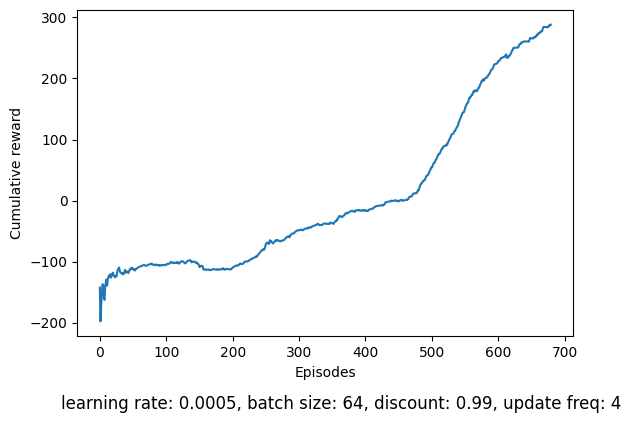

In [ ]:
"""
ECEN 743: Reinforcement Learning
Deep Q-Learning
Code tested using
	1. gymnasium 0.27.1
	2. box2d-py  2.3.5
	3. pytorch   2.0.0
	4. Python    3.9.12
1 & 2 can be installed using pip install gymnasium[box2d]

General Instructions
1. This code consists of TODO blocks, read them carefully and complete each of the blocks
2. Type your code between the following lines
			###### TYPE YOUR CODE HERE ######
			#################################
3. The default hyperparameters should be able to solve LunarLander-v2
4. You do not need to modify the rest of the code for this assignment, feel free to do so if needed.

"""
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import pickle

class ExperienceReplay:
	""" 
	Based on the Replay Buffer implementation of TD3 
	Reference: https://github.com/sfujim/TD3/blob/master/utils.py
	"""
	def __init__(self, state_dim, action_dim,max_size,batch_size,gpu_index=0):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.done = np.zeros((max_size, 1))		
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


	def add(self, state, action,reward,next_state, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.done[self.ptr] = done
		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self):
		ind = np.random.randint(0, self.size, size=self.batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).long().to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.done[ind]).to(self.device)
		)



class QNetwork(nn.Module):
	"""
	Q Network: designed to take state as input and give out Q values of actions as output
	"""

	def __init__(self, state_dim, action_dim):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
		"""
		super(QNetwork, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, action_dim)
		
	def forward(self, state):
		q = F.relu(self.l1(state))
		q = F.relu(self.l2(q))
		return self.l3(q)



class DQNAgent():

	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 tau=1e-3,
	 lr=5e-4,
	 update_freq=4,
	 max_size=int(1e5),
	 batch_size=64,
	 gpu_index=0
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			tau (float): used to update q-target
			lr (float): learning rate
			update_freq (int): update frequency of target network
			max_size (int): experience replay buffer size
			batch_size (int): training batch size
			gpu_index (int): GPU used for training
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.tau = tau
		self.lr = lr
		self.update_freq = update_freq
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


		# Setting up the NNs
		self.Q = QNetwork(state_dim, action_dim).to(self.device)
		self.Q_target = QNetwork(state_dim, action_dim).to(self.device)
		self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

		# Experience Replay Buffer
		self.memory = ExperienceReplay(state_dim,1,max_size,self.batch_size,gpu_index)
		
		self.t_train = 0
	
	def step(self, state, action, reward, next_state, done):
		"""
		1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
		2. Learns when the experience replay buffer has enough samples
		3. Updates target netowork
		"""
		self.memory.add(state, action, reward, next_state, done)	   
		self.t_train += 1 
					
		if self.memory.size > self.batch_size:
			experiences = self.memory.sample()
			self.learn(experiences, self.discount) #To be implemented
		
		if (self.t_train % self.update_freq) == 0:
			self.target_update(self.Q, self.Q_target, self.tau) #To be implemented 

	def select_action(self, state, epsilon=0.):
		"""
		TODO: Complete this block to select action using epsilon greedy exploration 
		strategy
		Input: state, epsilon
		Return: Action
		Return Type: int	
		"""
		###### TYPE YOUR CODE HERE ######
		# we have state and the Q network. we use these to obtain the Q values for current state and all actions, and notice the best action for this state
		self.Q.eval() # set to evaluation mode
		with torch.no_grad():
			state = torch.FloatTensor(state).to(self.device)
			q_values = self.Q(state)
			best_action = np.argmax(q_values.numpy(force=True))
		if np.random.random() < epsilon:
			# random action
			chosen_action =  np.random.randint(0,self.action_dim)
		else:
			# else return best action
			chosen_action =  best_action
		self.Q.train() # set to train mode
		return chosen_action
		################################# 

	def learn(self, experiences, discount):
		"""
		TODO: Complete this block to update the Q-Network using the target network
		1. Compute target using  self.Q_target ( target = r + discount * max_b [Q_target(s,b)] )
		2. Compute Q(s,a) using self.Q
		3. Compute MSE loss between step 1 and step 2
		4. Update your network
		Input: experiences consisting of states,actions,rewards,next_states and discount factor
		Return: None
		""" 		
		states, actions, rewards, next_states, dones = experiences
		###### TYPE YOUR CODE HERE ######
		# choose argmax action based on current Q network
		argmax_action = self.Q(next_states).detach().max(1)[1].unsqueeze(1)
		# get Q values from target network for next state
		q_val_target = self.Q_target(next_states).gather(1, argmax_action)
		target = rewards + discount * q_val_target * (1-dones)
		q_val = self.Q(states).gather(1,actions)
		self.optimizer.zero_grad()
		loss = F.mse_loss(q_val,target)
		loss.backward()
		self.optimizer.step()
		#################################


		                    

	def target_update(self, Q, Q_target, tau):
		"""
		TODO: Update the target network parameters (param_target) using current Q parameters (param_Q)
		Perform the update using tau, this ensures that we do not change the target network drastically
		1. param_target = tau * param_Q + (1 - tau) * param_target
		Input: Q,Q_target,tau
		Return: None
		""" 
		###### TYPE YOUR CODE HERE ######
		for param_target, param_Q in zip(Q_target.parameters(), Q.parameters()):
			param_target.data.copy_(tau*param_Q.data + (1.0-tau)*param_target.data)
		#################################


if __name__ == "__main__":
	parser = argparse.ArgumentParser()
	parser.add_argument("--env", default="LunarLander-v2")          # Gymnasium environment name
	parser.add_argument("--seed", default=0, type=int)              # sets Gym, PyTorch and Numpy seeds
	parser.add_argument("--n-episodes", default=2000, type=int)     # maximum number of training episodes
	parser.add_argument("--batch-size", default=64, type=int)       # training batch size
	parser.add_argument("--discount", default=0.99)                 # discount factor
	parser.add_argument("--lr", default=5e-4)                       # learning rate
	parser.add_argument("--tau", default=0.001)                     # soft update of target network
	parser.add_argument("--max-size", default=int(1e5),type=int)    # experience replay buffer length
	parser.add_argument("--update-freq", default=4, type=int)       # update frequency of target network
	parser.add_argument("--gpu-index", default=0,type=int)		    # GPU index
	parser.add_argument("--max-esp-len", default=1000, type=int)    # maximum time of an episode
	#exploration strategy
	parser.add_argument("--epsilon-start", default=1)               # start value of epsilon
	parser.add_argument("--epsilon-end", default=0.01)              # end value of epsilon
	parser.add_argument("--epsilon-decay", default=0.995)           # decay value of epsilon
	args = parser.parse_args(args=[])

	# making the environment	
	env = gym.make(args.env)
	env = gym.make(args.env,render_mode="rgb_array_list")
	env = gym.wrappers.RecordVideo(env=env,video_folder='./video')

	#setting seeds
	torch.manual_seed(args.seed)
	np.random.seed(args.seed)
	random.seed(args.seed)

	state_dim = env.observation_space.shape[0]
	action_dim = env.action_space.n

	kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":args.discount,
	 	"tau":args.tau,
	 	"lr":args.lr,
	 	"update_freq":args.update_freq,
	 	"max_size":args.max_size,
	 	"batch_size":args.batch_size,
	 	"gpu_index":args.gpu_index
	}	
	learner = DQNAgent(**kwargs) #Creating the DQN learning agent

	moving_window = deque(maxlen=100)
	smoothened_cumulative_reward_history = []
	consistency_count = 0
	epsilon = args.epsilon_start
	for e in range(args.n_episodes):
		state, _ = env.reset(seed=args.seed)
		curr_reward = 0
		for t in range(args.max_esp_len):
			action = learner.select_action(state,epsilon) #To be implemented
			n_state,reward,terminated,truncated,_ = env.step(action)
			done = terminated or truncated 
			learner.step(state,action,reward,n_state,done) #To be implemented
			state = n_state
			curr_reward += reward
			if done:
				break
		moving_window.append(curr_reward)

		""""
		TODO: Write code for decaying the exploration rate using args.epsilon_decay
		and args.epsilon_end. Note that epsilon has been initialized to args.epsilon_start  
		1. You are encouraged to try new methods
		"""
		###### TYPE YOUR CODE HERE ######
		epsilon = max(args.epsilon_end, epsilon * args.epsilon_decay)
		#################################	
		
		if e % 100 == 0:
			print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))
		
		""""
		TODO: Write code for
		1. Logging and plotting
		2. Rendering the trained agent 
		"""
		###### TYPE YOUR CODE HERE ######
		# log the avg cumulative reward
		smoothened_cumulative_reward_history.append(np.mean(moving_window))

		if np.mean(moving_window)>=200.:
			consistency_count += 1
			if consistency_count == 100:
				# means that our agent has achieved a cumulative reward of >=200 for the last 100 episodes
				# we can now stop our agent
				torch.save(learner.Q.state_dict(),'./model.ckpt')
				break
		else:
			consistency_count = 0
		
	# now that training has finished, we can plot cumulative reward vs episodes
	pickle.dump(smoothened_cumulative_reward_history,open('cum_rwe_history','wb'))
	# smoothened_cumulative_reward_history=pickle.load(open('cum_rwe_history','rb'))
	plt.subplots_adjust(bottom=0.2)
	plt.plot(smoothened_cumulative_reward_history)
	plt.xlabel('Episodes')
	plt.ylabel('Cumulative reward')
	plt.figtext(x=0.1,y=0.04,s=f'learning rate: {args.lr}, batch size: {args.batch_size}, discount: {args.discount}, update freq: {args.update_freq}',fontsize=12, va="bottom")
	plt.savefig('reward_plot.png')
	# next, we render the learned agent
	# load the saved model
	learner.Q.load_state_dict(torch.load('./model.ckpt'))
	learner.Q.eval()
	with torch.no_grad():
		for i in range(1):
			state,_ = env.reset()
			cum_reward = 0
			while True:
				# get the best action according to our Q-network
				action = np.argmax(learner.Q(torch.FloatTensor(state).to(learner.device)).numpy(force=True))
				env.render()
				state,reward,done,_,_ = env.step(action)
				cum_reward += reward
				if done:
					break
			print(f'Reward for this episode is {cum_reward}')
	env.close()
	#################################

In [ ]:
# 9m 44s - Lunar Lander r1
# 9m 40s - Lunar Lander r2
# 23m 48s - Lunar Lander r3 - Video
# 26m 52s - Acrobot - Video
# 54m 23s - Ablation 1 ?
# 48m 55s - Ablation 2
# 31m 57s - Lunar Lander DDQN - Video

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Episode Number 0 Average Episodic Reward (over 100 episodes): -142.22
Moviepy - Building video /content/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1.mp4
Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4
Moviepy - Building video /content/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/video/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4
Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4
Episode Number 100 Average Episodic Reward (over 100 episodes): -105.46
Moviepy - Building video /content/video/rl-video-episode-125.mp4.
Moviepy - Writing video /content/video/rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-125.mp4
Episode Number 200 Average Episodic Reward (over 100 episodes): -109.68
Moviepy - Building video /content/video/rl-video-episode-216.mp4.
Moviepy - Writing video /content/video/rl-video-episode-216.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-216.mp4
Episode Number 300 Average Episodic Reward (over 100 episodes): -48.57
Moviepy - Building video /content/video/rl-video-episode-343.mp4.
Moviepy - Writing video /content/video/rl-video-episode-343.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-343.mp4
Episode Number 400 Average Episodic Reward (over 100 episodes): -16.20
Episode Number 500 Average Episodic Reward (over 100 episodes): 54.10
Moviepy - Building video /content/video/rl-video-episode-512.mp4.
Moviepy - Writing video /content/video/rl-video-episode-512.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-512.mp4
Episode Number 600 Average Episodic Reward (over 100 episodes): 228.48
Reward for this episode is -268.5388782583413


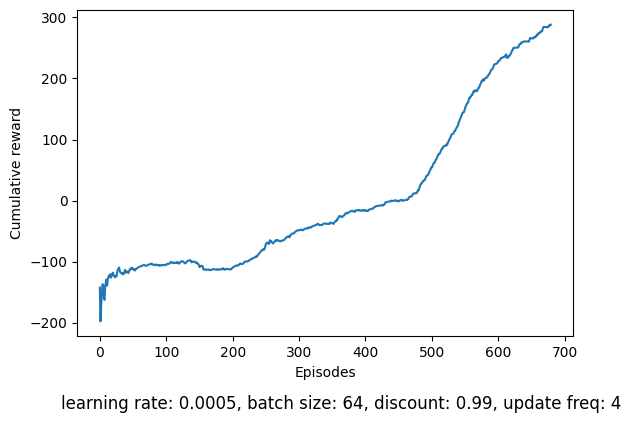

In [2]:
"""
ECEN 743: Reinforcement Learning
Deep Q-Learning
Code tested using
	1. gymnasium 0.27.1
	2. box2d-py  2.3.5
	3. pytorch   2.0.0
	4. Python    3.9.12
1 & 2 can be installed using pip install gymnasium[box2d]

General Instructions
1. This code consists of TODO blocks, read them carefully and complete each of the blocks
2. Type your code between the following lines
			###### TYPE YOUR CODE HERE ######
			#################################
3. The default hyperparameters should be able to solve LunarLander-v2
4. You do not need to modify the rest of the code for this assignment, feel free to do so if needed.

"""
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import pickle

class ExperienceReplay:
	""" 
	Based on the Replay Buffer implementation of TD3 
	Reference: https://github.com/sfujim/TD3/blob/master/utils.py
	"""
	def __init__(self, state_dim, action_dim,max_size,batch_size,gpu_index=0):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.done = np.zeros((max_size, 1))		
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')

	def add(self, state, action,reward,next_state, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.done[self.ptr] = done
		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self):
		ind = np.random.randint(0, self.size, size=self.batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).long().to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.done[ind]).to(self.device)
		)



class QNetwork(nn.Module):
	"""
	Q Network: designed to take state as input and give out Q values of actions as output
	"""

	def __init__(self, state_dim, action_dim):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
		"""
		super(QNetwork, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, action_dim)
		
	def forward(self, state):
		q = F.relu(self.l1(state))
		q = F.relu(self.l2(q))
		return self.l3(q)

class DQNAgent():

	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 tau=1e-3,
	 lr=5e-4,
	 update_freq=4,
	 max_size=int(1e5),
	 batch_size=64,
	 gpu_index=0
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			tau (float): used to update q-target
			lr (float): learning rate
			update_freq (int): update frequency of target network
			max_size (int): experience replay buffer size
			batch_size (int): training batch size
			gpu_index (int): GPU used for training
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.tau = tau
		self.lr = lr
		self.update_freq = update_freq
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')

		# Setting up the NNs
		self.Q = QNetwork(state_dim, action_dim).to(self.device)
		self.Q_target = QNetwork(state_dim, action_dim).to(self.device)
		self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

		# Experience Replay Buffer
		self.memory = ExperienceReplay(state_dim,1,max_size,self.batch_size,gpu_index)
		
		self.t_train = 0
	
	def step(self, state, action, reward, next_state, done):
		"""
		1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
		2. Learns when the experience replay buffer has enough samples
		3. Updates target netowork
		"""
		self.memory.add(state, action, reward, next_state, done)	   
		self.t_train += 1 
					
		if self.memory.size > self.batch_size:
			exp = self.memory.sample()
			self.learn(exp, self.discount) #To be implemented
		
		if (self.t_train % self.update_freq) == 0:
			self.target_update(self.Q, self.Q_target, self.tau) #To be implemented 

	def select_action(self, state, epsilon=0.):
		"""
		TODO: Complete this block to select action using epsilon greedy exploration 
		strategy
		Input: state, epsilon
		Return: Action
		Return Type: int	
		"""
		###### TYPE YOUR CODE HERE ######
		self.Q.eval() 
		with torch.no_grad():
			state = torch.FloatTensor(state).to(self.device)
			q_value = self.Q(state)
			best_act = np.argmax(q_value.numpy(force=True))
		if np.random.random() < epsilon:
			chosen_act =  np.random.randint(0,self.action_dim)
		else:
			chosen_act =  best_act
		self.Q.train() 
		return chosen_act
		################################# 

	def learn(self, experiences, discount):
		"""
		TODO: Complete this block to update the Q-Network using the target network
		1. Compute target using  self.Q_target ( target = r + discount * max_b [Q_target(s,b)] )
		2. Compute Q(s,a) using self.Q
		3. Compute MSE loss between step 1 and step 2
		4. Update your network
		Input: experiences consisting of states,actions,rewards,next_states and discount factor
		Return: None
		""" 		
		states, actions, rewards, next_states, dones = experiences
		###### TYPE YOUR CODE HERE ######
		argmax_action = self.Q(next_states).detach().max(1)[1].unsqueeze(1)
		q_val_target = self.Q_target(next_states).gather(1, argmax_action)
		targett = rewards + discount * q_val_target * (1-dones)
		q_val = self.Q(states).gather(1,actions)
		self.optimizer.zero_grad()
		loss = F.mse_loss(q_val,targett)
		loss.backward()
		self.optimizer.step()
		#################################


		                    

	def target_update(self, Q, Q_target, tau):
		"""
		TODO: Update the target network parameters (param_target) using current Q parameters (param_Q)
		Perform the update using tau, this ensures that we do not change the target network drastically
		1. param_target = tau * param_Q + (1 - tau) * param_target
		Input: Q,Q_target,tau
		Return: None
		""" 
		###### TYPE YOUR CODE HERE ######
		for param_target, param_Q in zip(Q_target.parameters(), Q.parameters()):
			param_target.data.copy_(tau*param_Q.data + (1.0-tau)*param_target.data)
		#################################


if __name__ == "__main__":
	parser = argparse.ArgumentParser()
	parser.add_argument("--env", default="LunarLander-v2")          # Gymnasium environment name
	parser.add_argument("--seed", default=0, type=int)              # sets Gym, PyTorch and Numpy seeds
	parser.add_argument("--n-episodes", default=2000, type=int)     # maximum number of training episodes
	parser.add_argument("--batch-size", default=64, type=int)       # training batch size
	parser.add_argument("--discount", default=0.99)                 # discount factor
	parser.add_argument("--lr", default=5e-4)                       # learning rate
	parser.add_argument("--tau", default=0.001)                     # soft update of target network
	parser.add_argument("--max-size", default=int(1e5),type=int)    # experience replay buffer length
	parser.add_argument("--update-freq", default=4, type=int)       # update frequency of target network
	parser.add_argument("--gpu-index", default=0,type=int)		    # GPU index
	parser.add_argument("--max-esp-len", default=1000, type=int)    # maximum time of an episode
	#exploration strategy
	parser.add_argument("--epsilon-start", default=1)               # start value of epsilon
	parser.add_argument("--epsilon-end", default=0.01)              # end value of epsilon
	parser.add_argument("--epsilon-decay", default=0.995)           # decay value of epsilon
	args = parser.parse_args(args=[])

	# making the environment	
	env = gym.make(args.env)
	env = gym.make(args.env,render_mode="rgb_array_list")
	env = gym.wrappers.RecordVideo(env=env,video_folder='./video')

	#setting seeds
	torch.manual_seed(args.seed)
	np.random.seed(args.seed)
	random.seed(args.seed)

	state_dim = env.observation_space.shape[0]
	action_dim = env.action_space.n

	kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":args.discount,
	 	"tau":args.tau,
	 	"lr":args.lr,
	 	"update_freq":args.update_freq,
	 	"max_size":args.max_size,
	 	"batch_size":args.batch_size,
	 	"gpu_index":args.gpu_index
	}	
	learner = DQNAgent(**kwargs) #Creating the DQN learning agent

	window = deque(maxlen=100)
	smoothened_cumulative_reward_history = []
	consistency_count = 0
	epsilon = args.epsilon_start
	for e in range(args.n_episodes):
		state, _ = env.reset(seed=args.seed)
		curr_reward = 0
		for t in range(args.max_esp_len):
			action = learner.select_action(state,epsilon) #To be implemented
			n_state,reward,terminated,truncated,_ = env.step(action)
			done = terminated or truncated 
			learner.step(state,action,reward,n_state,done) #To be implemented
			state = n_state
			curr_reward += reward
			if done:
				break
		window.append(curr_reward)

		""""
		TODO: Write code for decaying the exploration rate using args.epsilon_decay
		and args.epsilon_end. Note that epsilon has been initialized to args.epsilon_start  
		1. You are encouraged to try new methods
		"""
		###### TYPE YOUR CODE HERE ######
		epsilon = max(args.epsilon_end, epsilon * args.epsilon_decay)
		#################################	
		
		if e % 100 == 0:
			print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(window)))
		
		""""
		TODO: Write code for
		1. Logging and plotting
		2. Rendering the trained agent 
		"""
		###### TYPE YOUR CODE HERE ######
		reward_history.append(np.mean(window))

		if np.mean(window)>=200.:
			consistency_count += 1
			if consistency_count == 100:
				torch.save(learner.Q.state_dict(),'./model.ckpt')
				break
		else:
			consistency_count = 0

	pickle.dump(reward_history,open('cum_rwe_history','wb'))
	plt.subplots_adjust(bottom=0.2)
	plt.plot(reward_history)
	plt.xlabel('Training Episodes')
	plt.ylabel('Episodic Cumulative reward')
	learner.Q.load_state_dict(torch.load('./model.ckpt'))
	learner.Q.eval()
	with torch.no_grad():
		for i in range(1):
			state,_ = env.reset()
			cum_reward = 0
			while True:
				action = np.argmax(learner.Q(torch.FloatTensor(state).to(learner.device)).numpy(force=True))
				env.render()
				state,reward,done,_,_ = env.step(action)
				cum_reward += reward
				if done:
					break
			print(f'Reward for this episode is {cum_reward}')
	env.close()
	#################################